# Project Name: Predicting Home Prices in Banglore using ML and Auto SK Learn

### Context:
##### What are the things that a potential home buyer considers before purchasing a house? The location, the size of the property, vicinity to offices, schools, parks, restaurants, hospitals or the stereotypical white picket fence? What about the most important factor — the price?

Dataset is downloaded from here: https://www.kaggle.com/amitabhajoy/bengaluru-house-price-data

### We will be using different ML and Auto SK Learn Library (Auto ML) for this project.

## Time Line of the Project:
- Data Analysis
- Feature Engineering
- Model Building using ML
- Model Building using Auto SK Learn

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib 

<h2 style='color:white'>Data Load: Load banglore home prices into a dataframe</h2>

In [2]:
dataset = pd.read_csv('bengaluru_house_prices.csv')
dataset.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [4]:
dataset.shape

(13320, 9)

In [5]:
dataset['area_type'].value_counts()

area_type
Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: count, dtype: int64

**Drop features that are not required to build our model**

In [6]:
dataset = dataset.drop(['area_type','society','balcony','availability'],axis='columns')
dataset.shape

(13320, 5)

Data Cleaning: Handle NA values

In [7]:
dataset.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [8]:
dataset = dataset.dropna()

In [9]:
dataset.shape

(13246, 5)

Feature Engineering

**Add new feature(integer) for bhk (Bedrooms Hall Kitchen)**

In [10]:
dataset['bhk'] = dataset['size'].apply(lambda x: int(x.split(' ')[0]))
dataset.bhk.unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

In [11]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None   

In [12]:
dataset = dataset.copy()
dataset.total_sqft = dataset.total_sqft.apply(convert_sqft_to_num)
dataset = dataset[dataset.total_sqft.notnull()]
dataset.head(2)

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4


**Add new feature called price per square feet**

In [13]:
dataset['price_per_sqft'] = dataset['price']*100000/dataset['total_sqft']
dataset.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [14]:
dataset.to_csv("bhp.csv",index=False)

**Examine locations which is a categorical variable. We need to apply dimensionality reduction technique here to reduce number of locations**

In [15]:
dataset.location = dataset.location.apply(lambda x: x.strip())
location_stats = dataset['location'].value_counts(ascending=False)
location_stats

location
Whitefield                   533
Sarjapur  Road               392
Electronic City              304
Kanakpura Road               264
Thanisandra                  235
                            ... 
Rajanna Layout                 1
Subramanyanagar                1
Lakshmipura Vidyaanyapura      1
Malur Hosur Road               1
Abshot Layout                  1
Name: count, Length: 1287, dtype: int64

In [16]:
location_stats.values.sum()

13200

In [17]:
len(location_stats[location_stats>10])

240

In [18]:
len(location_stats)

1287

Dimensionality Reduction

**Any location having less than 10 data points will be tagged as "other" location. This way number of categories can be reduced by huge amount. It will help us with having fewer dummy columns**

In [20]:
location_stats_less_than_10 = location_stats[location_stats<=10]

In [21]:
dataset.location = dataset.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(dataset.location.unique())

241

Outlier removal Logic

**Normally square ft per bedroom is 300 (i.e. 2 bhk apartment is minimum 600 sqft. Example 400 sqft apartment with 2 bhk than that seems suspicious and can be removed as an outlier. We will remove such outliers by keeping our minimum thresold per bhk to be 300 sqft**

In [22]:
dataset[dataset.total_sqft/dataset.bhk<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


In [23]:
dataset.shape

(13200, 7)

In [24]:
dataset.price_per_sqft.describe()

count    1.320000e+04
mean     7.920759e+03
std      1.067272e+05
min      2.678298e+02
25%      4.267701e+03
50%      5.438331e+03
75%      7.317073e+03
max      1.200000e+07
Name: price_per_sqft, dtype: float64

**Here we find that min price per sqft is 267 rs/sqft whereas max is 176470, this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation**

In [24]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
dataset = remove_pps_outliers(dataset)
dataset.shape

(11434, 7)

**Let's check if for a given location how does the 2 BHK and 3 BHK property prices look like**

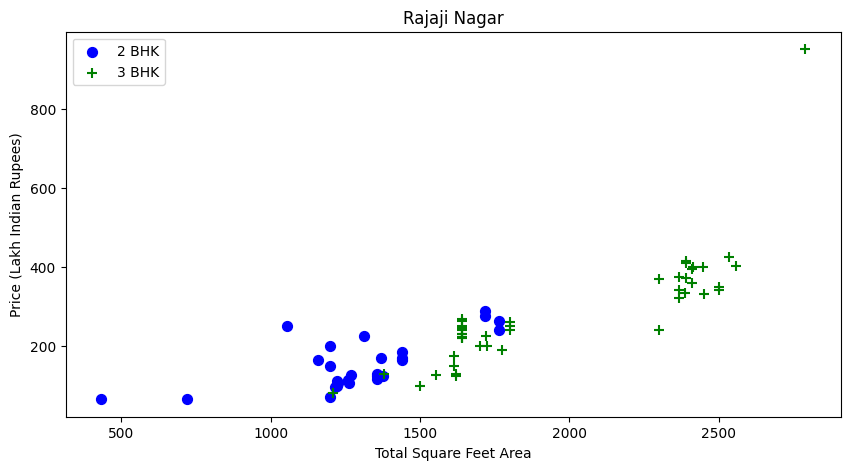

In [26]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (10,5)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(dataset,"Rajaji Nagar")

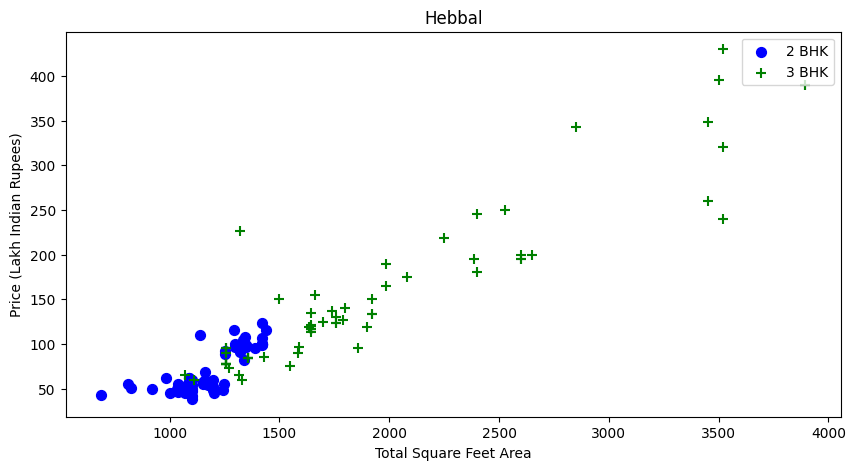

In [27]:
plot_scatter_chart(dataset,"Hebbal")

Outlier Removal Using Bathrooms Feature

In [31]:
dataset.bath.unique()

array([ 2.,  5.,  3.,  4.,  6.,  1.,  9.,  8.,  7., 11., 10., 14., 27.,
       12., 16., 40., 15., 13., 18.])

In [33]:
dataset[dataset.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
938,5th Phase JP Nagar,9 Bedroom,1260.0,11.0,290.0,9,23015.873016
1078,other,9 Bedroom,3300.0,14.0,500.0,9,15151.515152
1718,other,27 BHK,8000.0,27.0,230.0,27,2875.000000
1768,other,11 Bedroom,1200.0,11.0,170.0,11,14166.666667
1953,KR Puram,8 Bedroom,1200.0,12.0,110.0,8,9166.666667
1979,other,8 Bedroom,990.0,12.0,120.0,8,12121.212121
3096,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
3379,other,19 BHK,2000.0,16.0,490.0,19,24500.000000
3609,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
4684,Munnekollal,43 Bedroom,2400.0,40.0,660.0,43,27500.000000


**It is unusual to have 2 more bathrooms than number of bedrooms in a home**

In [34]:
dataset[dataset.bath>dataset.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1078,other,9 Bedroom,3300.0,14.0,500.0,9,15151.515152
1953,KR Puram,8 Bedroom,1200.0,12.0,110.0,8,9166.666667
1979,other,8 Bedroom,990.0,12.0,120.0,8,12121.212121
2620,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689
6838,Rajaji Nagar,5 BHK,7500.0,8.0,1700.0,5,22666.666667
6937,5th Block Hbr Layout,9 Bedroom,2600.0,12.0,675.0,9,25961.538462
7709,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
8106,other,8 Bedroom,1850.0,12.0,300.0,8,16216.216216
9974,other,3 Bedroom,2400.0,6.0,775.0,3,32291.666667
9990,other,6 Bedroom,1200.0,9.0,122.0,6,10166.666667


In [35]:
dataset = dataset[dataset.bath<dataset.bhk+2]
dataset.shape

(13026, 7)

In [36]:
dataset = dataset.drop(['size','price_per_sqft'],axis='columns')
dataset.head(3)

,location,total_sqft,bath,price,bhk
0,Electronic City Phase II,1056.0,2.0,39.07,2
1,Chikka Tirupathi,2600.0,5.0,120.00,4
2,Uttarahalli,1440.0,2.0,62.00,3


Use One Hot Encoding For Location

In [37]:
dummies = pd.get_dummies(dataset.location)
dummies.head(3)


,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [38]:
datasetII = pd.concat([dataset,dummies.drop('other',axis='columns')],axis='columns')
datasetII.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,Electronic City Phase II,1056.0,2.0,39.07,2,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,Chikka Tirupathi,2600.0,5.0,120.00,4,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,Uttarahalli,1440.0,2.0,62.00,3,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,Lingadheeranahalli,1521.0,3.0,95.00,3,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,Kothanur,1200.0,2.0,51.00,2,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [39]:
datasetII = datasetII.drop('location',axis='columns')

### Build a Model Now...

In [45]:
# Lets use the pycaret to build the model first 
from pycaret.regression import *

ImportError: cannot import name 'interp' from 'scipy' (c:\ProgramData\Anaconda3\envs\mlops\lib\site-packages\scipy\__init__.py)

In [46]:
X = datasetII.drop(['price'],axis='columns')
y = datasetII.price

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

In [48]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test,y_test)

0.4876011152036308

### Use K Fold cross validation to measure accuracy of LinearRegression model

In [50]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.4644905 , 0.48313457, 0.28754127, 0.4606162 , 0.26933287])

**We can see that in 5 iterations we get a score above 75% all the time. This is pretty good but we want to test few other algorithms for regression to see if we can get even better score.**

### Find best model using GridSearchCV

In [51]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

import warnings

# Turn off all warnings
warnings.filterwarnings("ignore")


def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': { 

            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }

    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y)

,model,best_score,best_params
0,linear_regression,0.393023,{}
1,lasso,0.332667,"{'alpha': 1, 'selection': 'cyclic'}"
2,decision_tree,0.321334,"{'criterion': 'friedman_mse', 'splitter': 'ran..."


In [52]:
pred= lr_clf.predict(X_test)

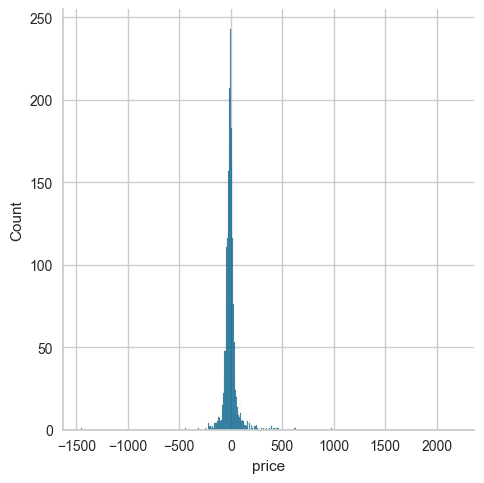

In [53]:
import seaborn as sns
sns.displot(y_test-pred)